In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import os

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [26]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

batch_size = 32
epochs = 5
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# change to the actual path
images_path = "E:\\IOAI\\kits\\nitro-nlp-25"

# Data preparation

In [27]:
class DuckDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.root_dir = root_dir
        self.df = self.prep_df(csv_file)

        self.target_size = (224, 224)

    def prep_df(self, csv_file):
        df = pd.read_csv(csv_file)

        # convert string of number to a proper list
        df["BoundingBox"] = (
            df["BoundingBox"].str.split().apply(lambda x: list(map(float, x)))
        )

        # feature engineering
        df["BoundingBoxArea"] = df["BoundingBox"].apply(
            lambda b: (b[2] - b[0]) * (b[3] - b[1])
        )
        df["Ratio"] = df["PixelCount"] / df["BoundingBoxArea"]
        # and now pixel_count = df["Ratio"] * df["BoundingBoxArea"]

        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row.iloc[0]
        img_path = os.path.join(self.root_dir, f"{filename}.png")
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        # 1. original bbox
        x1, y1, x2, y2 = row["BoundingBox"]

        # 2. resize image and scale bbox
        image = image.resize(self.target_size, resample=Image.BILINEAR)
        scale_x = self.target_size[0] / orig_w
        scale_y = self.target_size[1] / orig_h
        x1, x2 = x1 * scale_x, x2 * scale_x
        y1, y2 = y1 * scale_y, y2 * scale_y
        bbox = [x1, y1, x2, y2]

        # 3. random horizontal flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [W - x2, y1, W - x1, y2]

        # 4. random vertical flip
        if np.random.rand() < 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            W, H = self.target_size
            x1, y1, x2, y2 = bbox
            bbox = [x1, H - y2, x2, H - y1]

        # 5. convert to tensor
        image = transforms.ToTensor()(image)

        # 6. repare labels
        has_duck = torch.tensor([row["DuckOrNoDuck"]], dtype=torch.float32)
        pixel_count = torch.tensor([row["PixelCount"]], dtype=torch.float32)
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)

        return image, {
            "has_duck": has_duck,
            "pixel_count": pixel_count,
            "bbox": bbox_tensor,
        }

In [28]:
dataset = DuckDataset(
    csv_file="train_data.csv", root_dir=f"{images_path}\\train_dataset"
)

In [29]:
total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Exploratory Data Analysis

{'has_duck': tensor([1.]), 'pixel_count': tensor([1471.]), 'bbox': tensor([ 50.0153, 174.9822,  86.3511, 215.4504])}


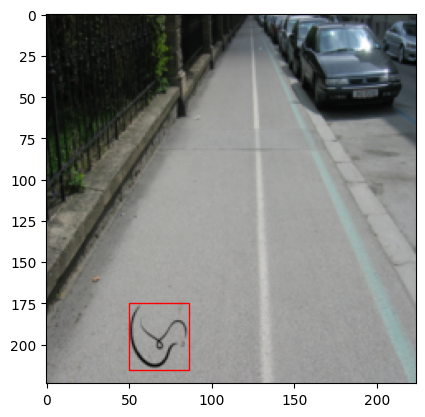

In [30]:
sample, labels = train_dataset[2]
sample = sample.permute(1, 2, 0)
print(labels) # is duck, pixel count, bounding box

fig, ax = plt.subplots()
ax.imshow(sample)

rect = patches.Rectangle(
    (labels["bbox"][0], labels["bbox"][1]),
    labels["bbox"][2] - labels["bbox"][0],
    labels["bbox"][3] - labels["bbox"][1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

# Subtask 1 - is there a duck?

In [31]:
class DuckNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.detect_duck = nn.Linear(64, 1)

    def forward(self, images):
        feats = self.backbone(images)
        is_duck = self.detect_duck(feats)
        return is_duck

In [32]:
ducknet = DuckNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(ducknet.parameters(), lr=lr)
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)

In [33]:
def train_ducknet():
    for epoch in range(1, epochs + 1):
        # train
        ducknet.train()
        train_loss = 0.0
        for images, labels in train_loader:
            imgs, targets = images.to(device), labels["has_duck"].to(device)

            # forwward pass
            preds = ducknet(imgs)
            loss = criterion(preds, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # stats for nerds
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # validation
        ducknet.eval()
        val_loss = 0.0
        accuracy_metric.reset()
        with torch.no_grad():
            for images, labels in val_loader:
                imgs = images.to(device)
                targets = labels['has_duck'].to(device)
                logits = ducknet(imgs)
                val_loss += criterion(logits, targets).item()
                preds = torch.sigmoid(logits)
                accuracy_metric.update(preds, targets.int())
        val_loss /= len(val_loader)
        val_acc = accuracy_metric.compute().item()

        print(
            f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )
    torch.save(ducknet.state_dict(), "ducknet.pth")

# current one trained for 5 epochs, 95% accuracy - 19/20
should_train = False
if should_train:
    train_ducknet()

    1/0 # stop the notebook execution

# Subtask 3 - bounding box
doing this one before 2

In [34]:
from ultralytics import YOLO

yolo = YOLO(f"{images_path}\\yolo\\duck.pt", verbose=False)

yolo config:
```yaml
path: .
train: images/train
val: images/val

names: ["no_duck", "duck"]
nc: 2
```

script:
```py
from ultralytics import YOLO
model = YOLO("./yolo11m.pt")
model.train(data="dataset.yaml", epochs=15, imgsz=640, device=0, batch=8)
```

In [35]:
def get_bounding_box(img: Image):
    pil_img_resized = img.resize((640, 640))
    result = yolo(pil_img_resized, verbose=False)[0]

    if len(result.boxes.xyxy) == 0:
        return torch.tensor([[0, 0, 0, 0]])

    xyxy = result.boxes.xyxy[0]
    norm = xyxy / 640

    width, height = img.size
    x1, y1, x2, y2 = norm[0] * width, norm[1] * height, norm[2] * width, norm[3] * height
    return torch.tensor([[x1, y1, x2, y2]])

In [36]:
img = Image.open("E:\\IOAI\\kits\\nitro-nlp-25\\test_dataset\\3.png")
bbox = get_bounding_box(img)[0].cpu()
bbox

tensor([314.9792,  66.6255, 446.1009, 169.6471])

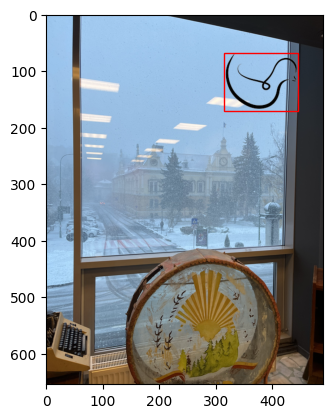

In [37]:
fig, ax = plt.subplots()
ax.imshow(img)

rect = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)

# Subtask 2 - pixel count

In [38]:
def preprocess_img_for2(img: Image, bbox: torch.Tensor):
    x1, y1, x2, y2 = [int(b) for b in bbox]
    img = img.crop((x1, y1, x2, y2))
    img = img.resize((64, 64)) 
    img = np.array(img, dtype=np.float32)
    return img.flatten() / 255


def setup_img_2(datapoint_id: int, bbox: list[int]):
    path = os.path.join(images_path, f"train_dataset\\{datapoint_id}.png")
    img = Image.open(path).convert("RGB")

    return preprocess_img_for2(img, bbox)


def get_df_2():
    df = pd.read_csv(f"./train_data.csv")
    df = df.drop(df[df["PixelCount"] == 0].index)

    df["BoundingBox"] = df["BoundingBox"].str.split().apply(lambda x: list(map(float, x)))

    df["Area"] = df["BoundingBox"].apply(lambda b: (b[2] - b[0]) * (b[3] - b[1]))
    df["SqrtArea"] = np.sqrt(df["Area"])
    df["Width"] = df["BoundingBox"].apply(lambda b: b[2] - b[0])
    df["Height"] = df["BoundingBox"].apply(lambda b: b[3] - b[1])
    df["AspectRatio"] = df["Width"] / df["Height"]

    # sklearn can't work with a column made out of a list
    # so we make each pixel its own column, this way we can use image + other features
    df["Image"] = df.apply(
        lambda x: setup_img_2(x["DatapointID"], x["BoundingBox"]), axis=1
    )
    image_features = pd.DataFrame(df["Image"].tolist()).add_prefix("img_")
    df = pd.concat([df, image_features], axis=1)

    df = df.dropna(axis=0)

    y = df["PixelCount"]
    X = df.drop(["PixelCount", "DuckOrNoDuck", "DatapointID", "Image", "BoundingBox"], axis=1)
    return X, y

X, y = get_df_2()
X.head()

,Area,SqrtArea,Width,Height,AspectRatio,img_0,img_1,img_2,img_3,img_4,...,img_12278,img_12279,img_12280,img_12281,img_12282,img_12283,img_12284,img_12285,img_12286,img_12287
0,6600.0,81.240384,75.0,88.0,0.852273,0.984314,0.964706,0.941176,0.929412,0.898039,...,0.392157,0.458824,0.439216,0.376471,0.564706,0.549020,0.486275,0.654902,0.639216,0.580392
2,8715.0,93.354164,105.0,83.0,1.265060,0.392157,0.615686,0.356863,0.407843,0.623529,...,0.270588,0.435294,0.596078,0.294118,0.501961,0.619608,0.360784,0.560784,0.631373,0.427451
3,5670.0,75.299402,81.0,70.0,1.157143,0.125490,0.098039,0.058824,0.133333,0.090196,...,0.286275,0.254902,0.231373,0.203922,0.200000,0.196078,0.200000,0.282353,0.247059,0.231373
4,11628.0,107.833205,114.0,102.0,1.117647,0.784314,0.796078,0.823529,0.788235,0.800000,...,0.827451,0.800000,0.803922,0.823529,0.792157,0.796078,0.815686,0.788235,0.792157,0.811765
5,4620.0,67.970582,66.0,70.0,0.942857,0.796078,0.803922,0.800000,0.807843,0.815686,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=seed,
)

In [40]:
svr = SVR()
svr.fit(X_train, y_train)

root_mean_squared_error(y_test, svr.predict(X_test))

1217.338396314674

In [41]:
gb = GradientBoostingRegressor(random_state=seed)
gb.fit(X_train, y_train)

root_mean_squared_error(y_test, gb.predict(X_test))

61.97316893007856

# Submission

In [42]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.lower().endswith(".png")]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.root_dir, fname)
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        base = os.path.splitext(fname)[0]
        return image, base


def prep_test_features(img: np.array, bbox: list[int]):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    area = width * height
    sqrtarea = np.sqrt(area)
    aspect_ratio = width / height if height != 0 else 0

    features = np.concatenate([[area, sqrtarea, width, height, aspect_ratio], img])

    meta_names = ["Area", "SqrtArea", "Width", "Height", "AspectRatio"]
    img_names = [f"img_{i}" for i in range(img.shape[0])]
    feature_names = meta_names + img_names

    return pd.DataFrame([features], columns=feature_names)


test_dataset = TestDataset(
    root_dir=f"{images_path}\\test_dataset",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    ),
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [43]:
ducknet = DuckNet()
ducknet.load_state_dict(torch.load("ducknet.pth"))
ducknet = ducknet.to(device)
ducknet.eval()

subtask1, subtask2, subtask3 = [], [], []

with torch.no_grad():
    for images, datapoints in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        logits = ducknet(images).squeeze(1)

        for datapoint, logit in zip(datapoints, logits):
            has_duck = int(torch.sigmoid(logit) >= 0.5)
            subtask1.append((1, datapoint, has_duck))

            if has_duck:
                img_path = os.path.join(test_dataset.root_dir, f"{datapoint}.png")
                pil_img = Image.open(img_path).convert("RGB")

                bbox = get_bounding_box(pil_img)[0]
                bbox_str = f"{int(bbox[0])} {int(bbox[1])} {int(bbox[2])} {int(bbox[3])}"

                img_2 = preprocess_img_for2(pil_img, bbox)
                feats = prep_test_features(img_2, bbox)
                pixel_cnt = int(gb.predict(feats)[0])
            else:
                bbox_str = "0 0 0 0"
                pixel_cnt = 0

            subtask2.append((2, datapoint, pixel_cnt))
            subtask3.append((3, datapoint, bbox_str))

Testing: 100%|██████████| 32/32 [01:38<00:00,  3.08s/it]


In [44]:
subtask1 = pd.DataFrame(subtask1, columns=["subtaskID", "datapointID", "answer"])
subtask2 = pd.DataFrame(subtask2, columns=["subtaskID", "datapointID", "answer"])
subtask3 = pd.DataFrame(subtask3, columns=["subtaskID", "datapointID", "answer"])

In [45]:
submission = pd.concat([subtask1, subtask2, subtask3], ignore_index=True)

submission.head()

,subtaskID,datapointID,answer
0,1,1,1
1,1,10,1
2,1,100,1
3,1,101,1
4,1,102,1


In [46]:
submission.to_csv("submission.csv", index=False)